In [1]:
import numpy as np 
from os import listdir, mkdir
from os.path import isdir
import cv2
from tqdm.notebook import tqdm
import pickle
from ScSR import ScSR
from backprojection import backprojection
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt


In [2]:

def normalize_signal(img, channel):
    if np.mean(img[:, :, channel]) * 255 > np.mean(img_lr_ori[:, :, channel]):
        ratio = np.mean(img_lr_ori[:, :, channel]) / (np.mean(img[:, :, channel]) * 255)
        img[:, :, channel] = np.multiply(img[:, :, channel], ratio)
    elif np.mean(img[:, :, channel]) * 255 < np.mean(img_lr_ori[:, :, channel]):
        ratio = np.mean(img_lr_ori[:, :, channel]) / (np.mean(img[:, :, channel]) * 255)
        img[:, :, channel] = np.multiply(img[:, :, channel], ratio)
    return img[:, :, channel]


In [3]:

def normalize_max(img):
    for m in range(img.shape[0]):
        for n in range(img.shape[1]):
            if img[m, n, 0] > 1:
                img[m, n, 0] = 1
            if img[m, n, 1] > 1:
                img[m, n, 1] = 1
            if img[m, n, 2] > 1:
                img[m, n, 2] = 1
    return img


In [4]:

# Set which dictionary you want to use
D_size = 2048
US_mag = 3
lmbd = 0.1
patch_size= 3

dict_name = str(D_size) + '_US' + str(US_mag) + '_L' + str(lmbd) + '_PS' + str(patch_size)

with open('data/dicts/Dh_' + dict_name + '.pkl', 'rb') as f:
    Dh = pickle.load(f)
Dh = normalize(Dh)
with open('data/dicts/Dl_' + dict_name + '.pkl', 'rb') as f:
    Dl = pickle.load(f)
Dl = normalize(Dl)

### SET PARAMETERS
img_lr_dir = 'data/val_lr/'
img_hr_dir = 'data/val_hr/'
overlap = 1
lmbd = 0.1
upscale = 3
maxIter = 100

###

img_lr_file = listdir(img_lr_dir)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

(31, 31) (31, 31) (31, 31)


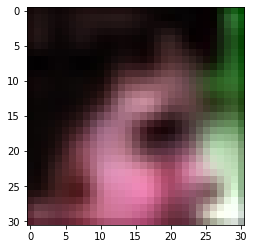

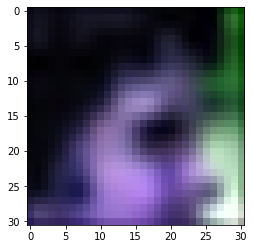

  0%|          | 0/255 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:

for i in tqdm(range(len(img_lr_file))):
    # Read test image
    img_name = img_lr_file[i]
    img_name_dir = list(img_name)
    img_name_dir = np.delete(np.delete(np.delete(np.delete(img_name_dir, -1), -1), -1), -1)
    img_name_dir = ''.join(img_name_dir)
    if isdir('data/results/' + dict_name + '_' + img_name_dir) == False:
        new_dir = mkdir('{}{}'.format('data/results/' + dict_name + '_', img_name_dir))
    img_lr = cv2.imread(img_lr_dir + img_name)

    # Read and save ground truth image
    img_hr = cv2.imread(img_hr_dir + img_name)
    cv2.imwrite('data/results/' + dict_name + '_' + img_name_dir + '/3HR.png', img_hr)
    img_hr_y = cv2.cvtColor(img_hr, cv2.COLOR_BGR2YCrCb)[:, :, 0]

    img_bc = cv2.resize(img_lr, (img_hr.shape[0], img_hr.shape[1]), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite('data/results/' + dict_name + '_' + img_name_dir + '/1bicubic.png', img_bc)
    
    # Change color space
    img_lr_ori = img_lr
    temp = img_lr
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2YCrCb)


    img_lr_y = img_lr[:, :, 0]
    img_lr_cb = img_lr[:, :, 1]
    img_lr_cr = img_lr[:, :, 2]

    # Upscale chrominance to color SR images
    img_sr_cb = cv2.resize(img_lr_cb, (img_hr.shape[0], img_hr.shape[1]), interpolation=cv2.INTER_CUBIC)
    img_sr_cr = cv2.resize(img_lr_cr, (img_hr.shape[0], img_hr.shape[1]), interpolation=cv2.INTER_CUBIC)

    # Super Resolution via Sparse Representation
    img_sr_y = ScSR(img_lr_y, img_hr_y.shape, upscale, Dh, Dl, lmbd, overlap)

    img_sr_y = backprojection(img_sr_y, img_lr_y, maxIter)

    # Create colored SR images
    img_sr = np.clip(np.stack((img_sr_y, img_sr_cb, img_sr_cr), axis=2), 0, 255).astype('uint8')
    plt.imshow(cv2.cvtColor(img_sr, cv2.COLOR_YCrCb2RGB)), plt.show()
    img_sr = cv2.cvtColor(img_sr, cv2.COLOR_YCrCb2BGR)

    # Bicubic interpolation for reference
    img_bc = cv2.resize(img_lr_ori, (img_hr.shape[0], img_hr.shape[1]), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite('data/results/' + dict_name + '_' + img_name_dir + '/1bicubic.png', img_bc)
    img_bc_y = cv2.cvtColor(img_bc, cv2.COLOR_BGR2YCrCb)[:, :, 0]

    # Compute RMSE for the illuminance
    rmse_bc_hr = np.sqrt(mean_squared_error(img_hr_y, img_bc_y))
    rmse_bc_hr = np.zeros((1,)) + rmse_bc_hr
    rmse_sr_hr = np.sqrt(mean_squared_error(img_hr_y, img_sr_y))
    rmse_sr_hr = np.zeros((1,)) + rmse_sr_hr
    np.savetxt('{}{}{}{}'.format('data/results/' + dict_name + '_', img_name_dir, '/', 'RMSE_bicubic.txt'), rmse_bc_hr)
    np.savetxt('{}{}{}{}'.format('data/results/' + dict_name + '_', img_name_dir, '/', 'RMSE_SR.txt'), rmse_sr_hr)

    cv2.imwrite('data/results/' + dict_name + '_' + img_name_dir + '/2SR.png', img_sr)